In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#여기서는 데이터 색에 맞게 legend하기 위해 사용
import matplotlib.patches as mpatches
import seaborn as sns
import time

from scipy.stats import norm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, \
accuracy_score, classification_report, roc_curve, precision_recall_curve, \
average_precision_score, confusion_matrix, classification_report
import collections

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
#cross_val_score에서 cv의 매개변수로 넘겨줌(kfold는 세밀한 분류를 할 때, stratifiedkfold는 분포유지하고 싶을때)
#분류 모델일 때 StratifiedKFold가 좋다
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit, learning_curve
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

#버전에 대한 정보 같은 경고메세지 숨기기
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type

In [2]:
data=pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.isnull().sum().max()

0

In [11]:
#fraud비율이 매우 작아서 제대로 된 학습이 이뤄지지 않을 것 같다.
#data['Class']==1 이면 fraud
fraud_rate=round(data['Class'].value_counts()[1]/len(data)*100,2)
print('Fraud',fraud_rate,'%')
print('otherwise',100-fraud_rate,'%')

Fraud 0.17 %
otherwise 99.83 %


In [3]:
#scale된 다른 변수들과 달리 아직 scale되지 않은 time과 amount변수 scale해줌
std_scaler=StandardScaler()
rob_scaler=RobustScaler()

scaled_amount=rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
scaled_time=rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.insert(0,'scaled_amount',scaled_amount)
data.insert(1,'scaled_time',scaled_time)
data.drop(['Time','Amount'],axis=1,inplace=True)

data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [4]:
X=data.drop('Class',axis=1)
y=data['Class']

#StratifiedKFold->각 fold의 label 분포가 전체 데이터셋의 label 분포를 잘 대표한다.
#훈련과 테스트로 나눌 때 기존 데이터의 분포를 유지하면서 나눔
s_kfold=StratifiedKFold(n_splits=5,random_state=None,shuffle=False)

for train_index,test_index in s_kfold.split(X,y):
    original_Xtrain, original_Xtest=X.iloc[train_index],X.iloc[test_index]
    original_ytrain, original_ytest=y.iloc[train_index],y.iloc[test_index]
#DataFrame으로 된 것을 np.ndarray형태로 바꿔준다.(인덱스를 뺀 값만 가져옴)
original_Xtrain=original_Xtrain.values
original_Xtest=original_Xtest.values
original_ytrain=original_ytrain.values
original_ytest=original_ytest.values

#train과 test가 같은 분포를 이루고 있는지 확인
#return_counts->개수를 세서 반환해준다.
_,train_label_count=np.unique(original_ytrain,return_counts=True)
_,test_label_count=np.unique(original_ytest,return_counts=True)

print('Label Distribution:')
print(train_label_count/len(original_ytrain))
print(test_label_count/len(original_ytest))

Label Distribution:
[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [5]:
#sample->랜덤하게 return, frac->return할 비율(1이면 100%)
data=data.sample(frac=1)

fraud_data=data.loc[data['Class']==1]
non_fraud_data=data.loc[data['Class']==0][:492]
normal_distributed_data=pd.concat([fraud_data,non_fraud_data])
new_data=normal_distributed_data.sample(frac=1,random_state=42)

new_data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
252232,1.089918,0.834385,-1.676197,-0.084551,2.375502,0.991711,0.010279,0.427390,-0.491703,0.439157,...,0.352196,0.159287,0.683855,-0.273717,0.723314,0.494532,-0.285886,0.543905,0.285777,0
102782,-0.033676,-0.191908,1.232604,-0.548931,1.087873,0.894082,-1.433055,-0.356797,-0.717492,0.003167,...,-0.576274,-0.448671,-0.517568,0.012833,0.699217,0.527258,-0.322607,0.080805,0.035427,1
185938,-0.293440,0.495671,2.022412,0.081902,-1.731293,1.207414,0.510911,-0.677244,0.417155,-0.159826,...,-0.396766,0.057283,0.300917,-0.029223,-0.433600,0.421142,-0.480459,-0.027795,-0.080246,0
44556,-0.293440,-0.501662,-4.566342,3.353451,-4.572028,3.616119,-2.493138,-1.090000,-5.551433,0.447783,...,-0.249128,2.674466,-0.020880,-0.302447,-0.086396,-0.516060,-0.295102,0.195985,0.141115,1
6427,-0.293440,-0.905579,0.725646,2.300894,-5.329976,4.007683,-1.730411,-1.732193,-3.968593,1.063728,...,0.504646,0.589669,0.109541,0.601045,-0.364700,-1.843078,0.351909,0.594550,0.099372,1


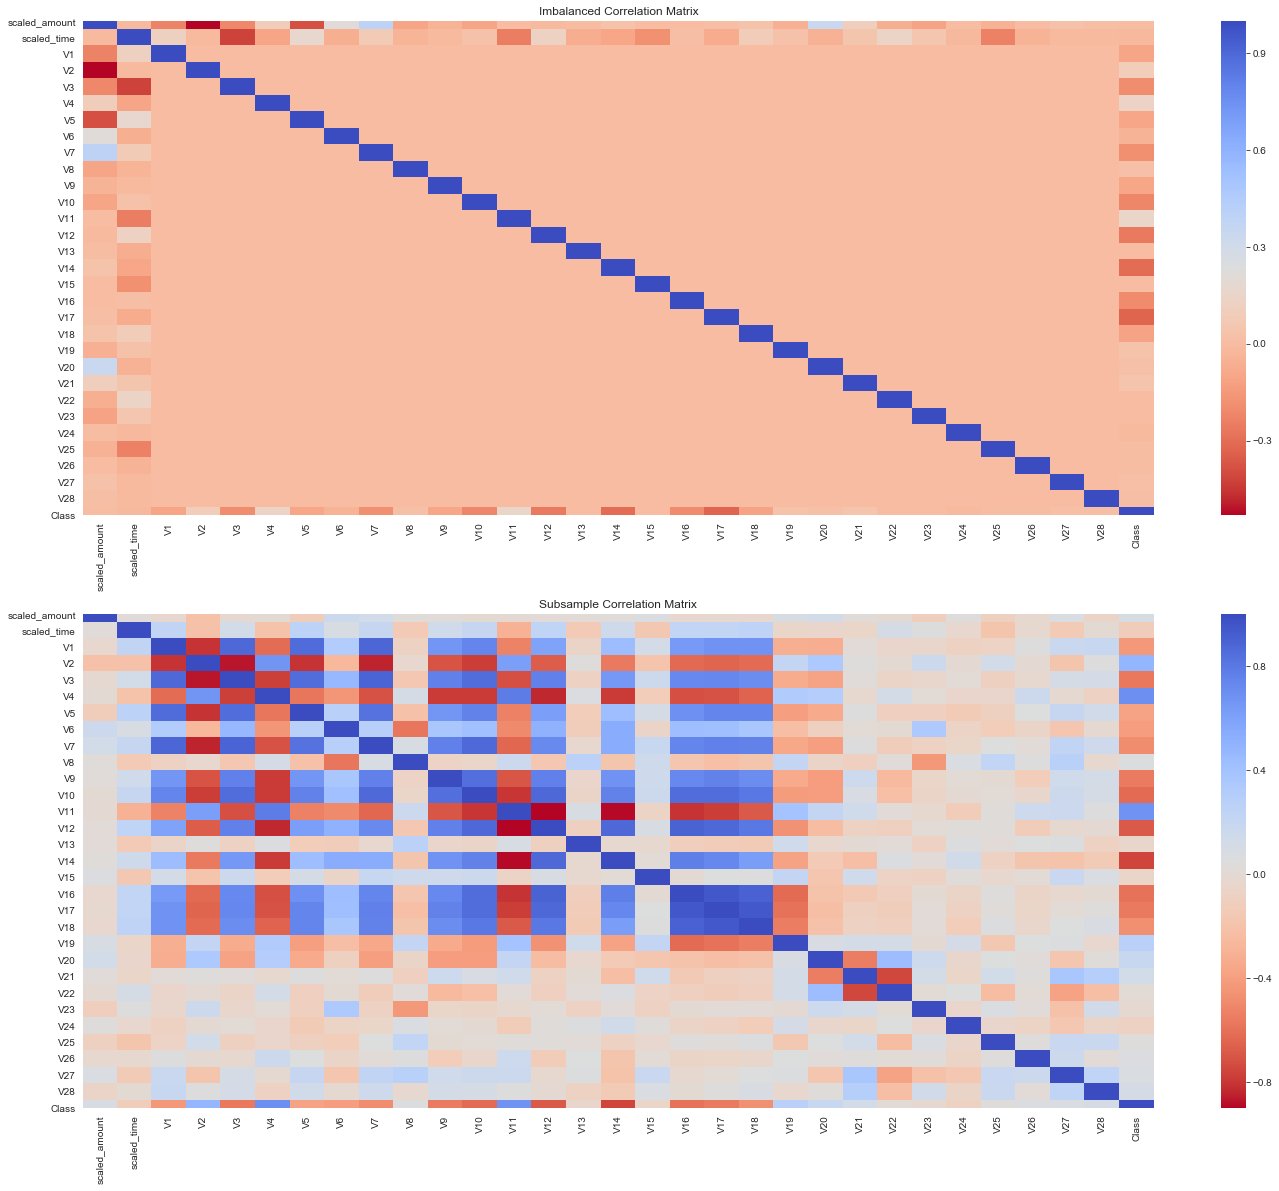

In [25]:
f,(ax1,ax2)=plt.subplots(2,1,figsize=(24,20))
sns.set_style(style='whitegrid')
#fraud와 non fraud의 비율이 다른 데이터
corr=data.corr()
sns.heatmap(corr,cmap='coolwarm_r',annot_kws={'size':20},ax=ax1)
ax1.set_title('Imbalanced Correlation Matrix')

#비율이 같은 데이터
sub_corr=new_data.corr()
sns.heatmap(sub_corr,cmap='coolwarm_r',annot_kws={'size':20},ax=ax2)
ax2.set_title('Subsample Correlation Matrix')

plt.show()

In [41]:
#Class와 상관관계가 -0.5보다 작은 특성들(lower->non fraud)
negative=[(y,x) for x,y in zip(sub_corr['Class'],sub_corr.index) if x<-0.5]
negative.sort(key=lambda x: x[1])
negative

[('V14', -0.7527746313421761),
 ('V12', -0.6823082881522055),
 ('V10', -0.6242086251981928),
 ('V16', -0.5915251327765274),
 ('V3', -0.5709428287166213),
 ('V17', -0.5600309026860492),
 ('V9', -0.5558256986364654)]

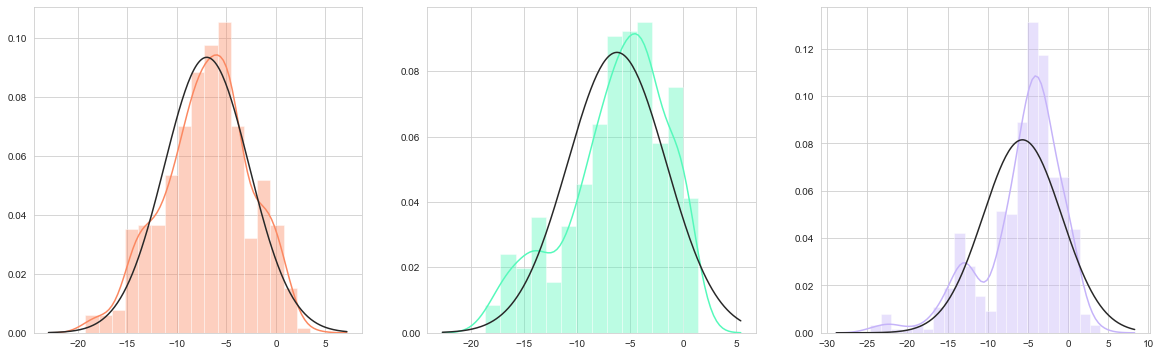

In [6]:
sns.set_style(style='whitegrid')
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,6))

v14_fraud=new_data['V14'].loc[new_data['Class']==1].values
#fit=norm->검은 선으로 정규분포의 모양을 나타냄
sns.distplot(v14_fraud,ax=ax1,fit=norm,color='#FB8861')

v12_fraud=new_data['V12'].loc[new_data['Class']==1].values
sns.distplot(v12_fraud,ax=ax2,fit=norm,color='#56F9BB')

v10_fraud=new_data['V10'].loc[new_data['Class']==1].values
#fit=norm->검은 선으로 정규분포의 모양을 나타냄
sns.distplot(v10_fraud,ax=ax3,fit=norm,color='#C5B3F9')

plt.show()

In [7]:
#outlier 제거
#75~25사이 범위에서 앞뒤로 1.5배만큼 여유를 둔다.
print('V14')
#np.percentile->위치를 1/100 단위로 나눈 백분위수를 구해줌
q25,q75=np.percentile(v14_fraud,25),np.percentile(v14_fraud,75)
print('Quartile 25:{:.4f}, 75:{:.4f}'.format(q25,q75))
#iqr->interquartile range: 75%~25%
v14_iqr=q75-q25
v14_cut=v14_iqr*1.5
v14_lower,v14_upper=q25-v14_cut,q75+v14_cut
print('Cut_off:{:.4f}, Lower:{:.4f}, Upper:{:.4f}'.format(v14_cut,v14_lower,v14_upper))
outliers=[x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('V14 outliers:{}'.format(outliers))
new_data=new_data.drop(new_data[(new_data['V14']>v14_upper) | (new_data['V14']<v14_lower)].index)
print('----'*40)

print('V12')
q25,q75=np.percentile(v12_fraud,25),np.percentile(v12_fraud,75)
print('Quartile 25:{:.4f}, 75:{:.4f}'.format(q25,q75))
v12_iqr=q75-q25
v12_cut=v12_iqr*1.5
v12_lower,v12_upper=q25-v12_cut,q75+v12_cut
print('Cut_off:{:.4f}, Lower:{:.4f}, Upper:{:.4f}'.format(v12_cut,v12_lower,v12_upper))
outliers=[x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers:{}'.format(outliers))
new_data=new_data.drop(new_data[(new_data['V12']>v12_upper)|(new_data['V12']<v12_lower)].index)
print('----'*40)

print('V10')
q25,q75=np.percentile(v10_fraud,25),np.percentile(v10_fraud,75)
print('Quartile 25:{:.4f}, 75:{:.4f}'.format(q25,q75))
v10_iqr=q75-q25
v10_cut=v10_iqr*1.5
v10_lower,v10_upper=q25-v10_cut,q75+v10_cut
print('Cut_off:{:.4f}, Lower:{:.4f}, Upper:{:.4f}'.format(v10_cut,v10_lower,v10_upper))
outliers=[x for x in v10_fraud if x > v10_upper or x < v10_lower]
print('V10 outliers:{}'.format(outliers))
new_data=new_data.drop(new_data[(new_data['V10'] > v10_upper)|(new_data['V10'] < v10_lower)].index)
print('\n\nAfter remove outliers data shape:',new_data.shape)

V14
Quartile 25:-9.6927, 75:-4.2828
Cut_off:8.1149, Lower:-17.8076, Upper:3.8320
V14 outliers:[-18.8220867423816, -18.049997689859396, -18.4937733551053, -19.2143254902614]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
V12
Quartile 25:-8.6882, 75:-2.9741
Cut_off:8.5711, Lower:-17.2593, Upper:5.5970
V12 outliers:[-18.047596570821604, -18.683714633344298, -18.4311310279993, -17.631606313870698, -18.553697009645802, -17.7691434633638]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
V10
Quartile 25:-7.7567, 75:-2.6142
Cut_off:7.7138, Lower:-15.4705, Upper:5.0996
V10 outliers:[-22.1870885620007, -18.2711681738888, -24.5882624372475, -16.3035376590131, -17.141513641289198, -16.2556117491401, -24.403184969972802, -16.6496281595399, -23.2282548357516, -22.1870885620007,

In [8]:
X=new_data.drop('Class',axis=1)
y=new_data['Class']

t0=time.time()
X_reduced_tsne=TSNE(n_components=2,random_state=42).fit_transform(X.values)
t1=time.time()
print('T-SNE took {:.2f} s'.format(t1-t0))

t0=time.time()
X_reduced_pca=PCA(n_components=2,random_state=42).fit_transform(X.values)
t1=time.time()
print('PCA took {:.2f} s'.format(t1-t0))

t0=time.time()
X_reduced_svd=TruncatedSVD(n_components=2,algorithm='randomized',random_state=42).fit_transform(X.values)
t1=time.time()
print('Truncated SVD took {:.2f} s'.format(t1-t0))

T-SNE took 6.39 s
PCA took 0.00 s
Truncated SVD took 0.02 s


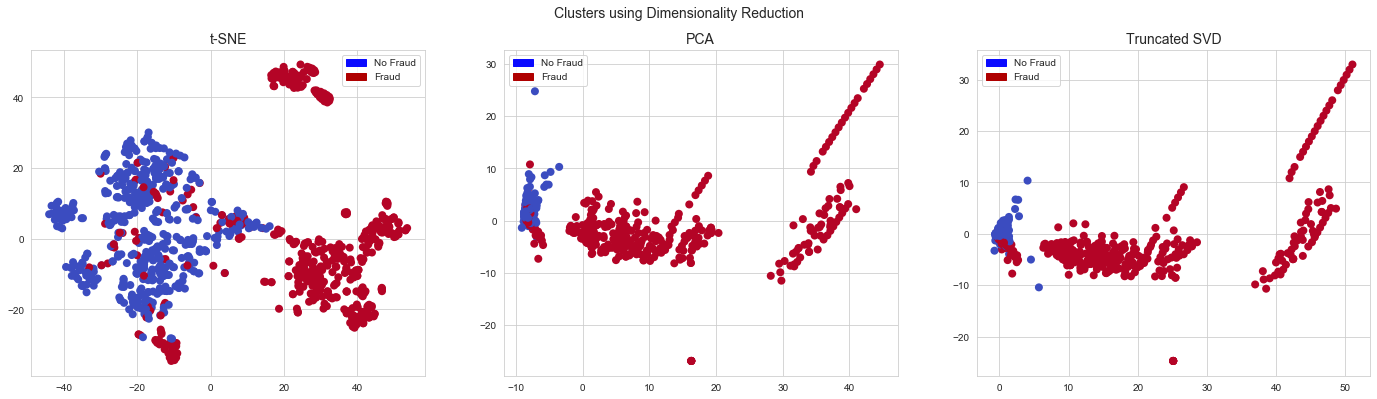

In [93]:
sns.set_style(style='whitegrid')
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction',fontsize=14)
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

#c->color 1과 0에 따라 색 분류 1:red, 0:blue
#c=(y==0)과 같은 표현으로 두가지 색을 동시에 나타낼 수 있다.
ax1.scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1],c=(y==1),cmap='coolwarm',label='No Fraud',linewidths=2)
ax1.set_title('t-SNE',fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch,red_patch])

ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [9]:
X=new_data.drop('Class',axis=1)
y=new_data['Class']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

classifiers={
    "LogisticRegression":LogisticRegression(),
    "KNearest":KNeighborsClassifier(),
    "Support Vector Classifier":SVC(),
    "DecisionTreeClassifier":DecisionTreeClassifier()
}
#overfitting 방지하기 위해서 교차검증실시
for key,classifier in classifiers.items():
    classifier.fit(X_train,y_train)
    training_score=cross_val_score(classifier,X_train,y_train,cv=5)
    print("Classifier: ",classifier.__class__.__name__,
          " Training Score: ",round(training_score.mean(),2)*100,"% accuracy score")

Classifier:  LogisticRegression  Training Score:  94.0 % accuracy score
Classifier:  KNeighborsClassifier  Training Score:  93.0 % accuracy score
Classifier:  SVC  Training Score:  93.0 % accuracy score
Classifier:  DecisionTreeClassifier  Training Score:  90.0 % accuracy score


In [10]:
log_reg_params={"penalty":['l1','l2'],'C':[0.001,0.01,0.1,1,10,100,1000]}

grid_log_reg=GridSearchCV(LogisticRegression(),log_reg_params).fit(X_train,y_train)
log_reg=grid_log_reg.best_estimator_

knears_params={"n_neighbors":list(range(2,5,1)),'algorithm':['auto','ball_tree','kd_tree','brute']}
grid_knears=GridSearchCV(KNeighborsClassifier(),knears_params).fit(X_train,y_train)
knears_neighbors=grid_knears.best_estimator_
#C->작을 수록 모델 단순화
svc_params={'C':[0.5,0.7,0.9,1],'kernel':['rbf','poly','sigmoid','linear']}
grid_svc=GridSearchCV(SVC(),svc_params).fit(X_train,y_train)
svc=grid_svc.best_estimator_

tree_params={"criterion":['gini',"entropy"],"max_depth":list(range(2,4,1)),"min_samples_leaf":list(range(5,7,1))}
grid_tree=GridSearchCV(DecisionTreeClassifier(),tree_params).fit(X_train,y_train)
tree_clf=grid_tree.best_estimator_

In [11]:
skf=StratifiedKFold(n_splits=5,random_state=None,shuffle=False)

log_reg_score=cross_val_score(log_reg,X_train,y_train,cv=5)
log_reg_score_skf=cross_val_score(log_reg,X_train,y_train,cv=skf)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%, ',
     'StratifiedKFold: ',round(log_reg_score_skf.mean()*100,2).astype(str),'%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
knears_score_skf = cross_val_score(knears_neighbors, X_train, y_train, cv=skf)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '% ',
     'StratifiedKFold: ',round(knears_score_skf.mean()*100,2).astype(str),'%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.24%,  StratifiedKFold:  94.37 %
Knears Neighbors Cross Validation Score 94.5%  StratifiedKFold:  94.5 %
Support Vector Classifier Cross Validation Score 94.11%
DecisionTree Classifier Cross Validation Score 92.14%


In [12]:
##################cross validation 전에 over or under sampling 하면 안 됨#########
#훈련 데이터만 처리해야지 테스트 데이터까지 처리하면 안 됨

#비대칭인 데이터 under sample적용
undersample_X=data.drop('Class',axis=1)
undersample_y=data['Class']
skf=StratifiedKFold(n_splits=5,random_state=None, shuffle=False)
#5번째 추출 index로 데이터 형성
for train_index, test_index in skf.split(undersample_X, undersample_y):
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values
#tp: true positive, fp: false positive, tn: true negative, fn: false negative
#accuracy->(tp+tn)/(tp+tn+fp+fn)  fp와 fn의 크기가 비슷할 때 유용
undersample_accuracy = []
#precision->tp/(tp+fp)
undersample_precision = []
#recall->tp/(tp+fn)
undersample_recall = []
#f1 score=(2*recall*precision)/(recall+precision)
#fn과 fp 크기 차이가 많이 날 때 유용
undersample_f1 = []
#roc auc->area of under the roc curve
#roc curve->x축:0을 틀린확률, y축:1을 맞춘 확률 커브가 좌상단에 몰릴 수록 좋음(예측력 높음)
undersample_auc = []
#나눈 샘플을 undersample모듈인 nearmiss에 학습시킨다.
X_nearmiss,y_nearmiss=NearMiss().fit_sample(undersample_X.values,undersample_y.values)

for train, test in skf.split(undersample_Xtrain,undersample_ytrain):
    undersample_pipeline=imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'),log_reg)
    undersample_model=undersample_pipeline.fit(undersample_Xtrain[train],undersample_ytrain[train])
    undersample_prediction=undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test],original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test],undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test],undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

In [13]:
log_reg_pred=cross_val_predict(log_reg, X_train, y_train, cv = 5, method = 'decision_function')
knears_pred=cross_val_predict(knears_neighbors, X_train, y_train, cv = 5)
svc_pred=cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
tree_pred=cross_val_predict(tree_clf, X_train, y_train, cv=5)

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Regression: ', roc_auc_score(y_train, knears_pred))
print('Support Regression: ', roc_auc_score(y_train, svc_pred))
print('Decision Regression: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9800898768481355
KNears Regression:  0.9439813385475626
Support Regression:  0.9822441768721484
Decision Regression:  0.9203046207677267


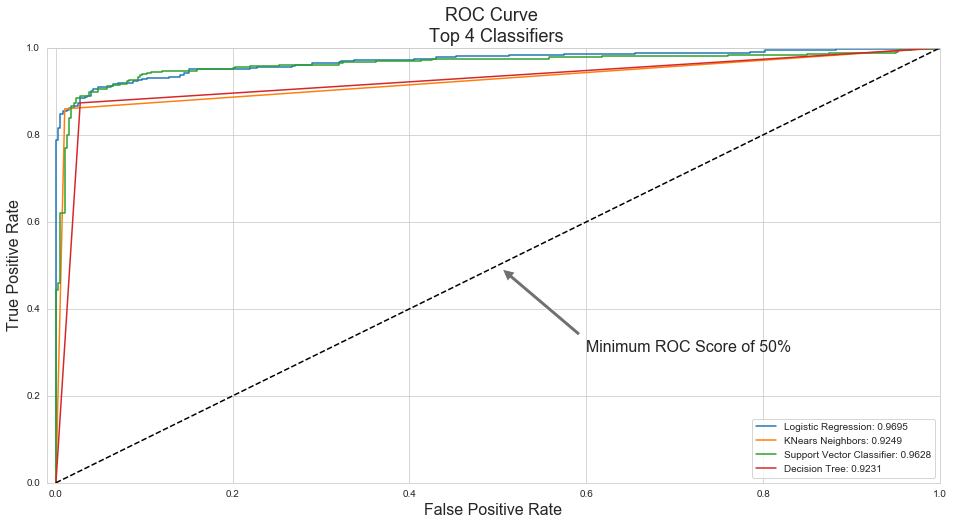

In [34]:
#fpr->false positive rate, tpr->true positive rate (>=threshold)
log_fpr, log_tpr, log_threshold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

sns.set_style(style='whitegrid')
plt.figure(figsize=(16,8))
plt.title('ROC Curve \n Top 4 Classifiers',fontsize=18)
plt.plot(log_fpr, log_tpr, label='Logistic Regression: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors: {:.4f}'.format(roc_auc_score(y_train,knears_pred)))
plt.plot(svc_fpr,svc_tpr,label='Support Vector Classifier: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
plt.plot(tree_fpr, tree_tpr, label='Decision Tree: {:.4f}'.format(roc_auc_score(y_train,tree_pred)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50%', xy=(0.5, 0.5), xytext=(0.6,0.3),
            arrowprops=dict(facecolor='#6E726D',shrink=0.05), fontsize=16)
plt.legend()
plt.show()

In [36]:
precision, recall, threshold=precision_recall_curve(y_train, log_reg_pred)
y_pred=log_reg.predict(X_train)

print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}\n'.format(accuracy_score(y_train, y_pred)))

# How it should look like
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))


Overfitting: 

Recall Score: 0.95
Precision Score: 0.68
F1 Score: 0.79
Accuracy Score: 0.76

How it should be:

Accuracy Score: 0.53
Precision Score: 0.00
Recall Score: 0.41
F1 Score: 0.00


In [50]:
undersample_y_score=log_reg.decision_function(original_Xtest)
undersample_average_precision=average_precision_score(original_ytest,undersample_y_score)
print('Average Precision-Recall Score: {:.2f}'.format(undersample_average_precision))

Average Precision-Recall Score: 0.02


In [14]:
#매우 오래걸림 
accuracy_list=[]
precision_list=[]
recall_list=[]
f1_list=[]
auc_list=[]

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#RandomizedSearchCV->Grid에 비해 빠르지만 정확도는 조금 떨어짐
#n_iter->default는 10으로 미리 고정시킬 parameter의 개수(클수록 빠르지만 부정확)
rand_log_reg = RandomizedSearchCV(LogisticRegression(),log_reg_params, n_iter=4)
for train, test in skf.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'),rand_log_reg)
    model = pipeline.fit(original_Xtrain[train],original_ytrain[train])
    best_est=rand_log_reg.best_estimator_
    prediction=best_est.predict(original_Xtrain[test])
    
    #pipeline.score==best_est.score
    accuracy_list.append(pipeline.score(original_Xtrain[test],original_ytrain[test]))
    precision_list.append(precision_score(original_ytrain[test], prediction))
    recall_list.append(recall_score(original_ytrain[test],prediction))
    f1_list.append(f1_score(original_ytrain[test],prediction))
    auc_list.append(roc_auc_score(original_ytrain[test],prediction))
print("accuracy: {}".format(np.mean(accuracy_list)))
print("precision: {}".format(np.mean(precision_list)))
print("recall: {}".format(np.mean(recall_list)))
print("f1: {}".format(np.mean(f1_list)))

accuracy: 0.9427997694618024
precision: 0.06392617684982227
recall: 0.9136319376825707
f1: 0.1176729552072198


In [15]:
#over sampling으로 구한 정확도의 평균
y_score=best_est.decision_function(original_Xtest)
average_precision=average_precision_score(original_ytest, y_score)
print('Average Precision-Recall Score: {:.2f}'.format(average_precision))

Average Precision-Recall Score: 0.75


In [27]:
sm = SMOTE(ratio='minority', random_state=42)
#original->fraud와 non fraud의 비율을 맞춘 데이터
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
#log_reg_sm->gridsearchcv의 best_estimator_
log_reg_sm=rand_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

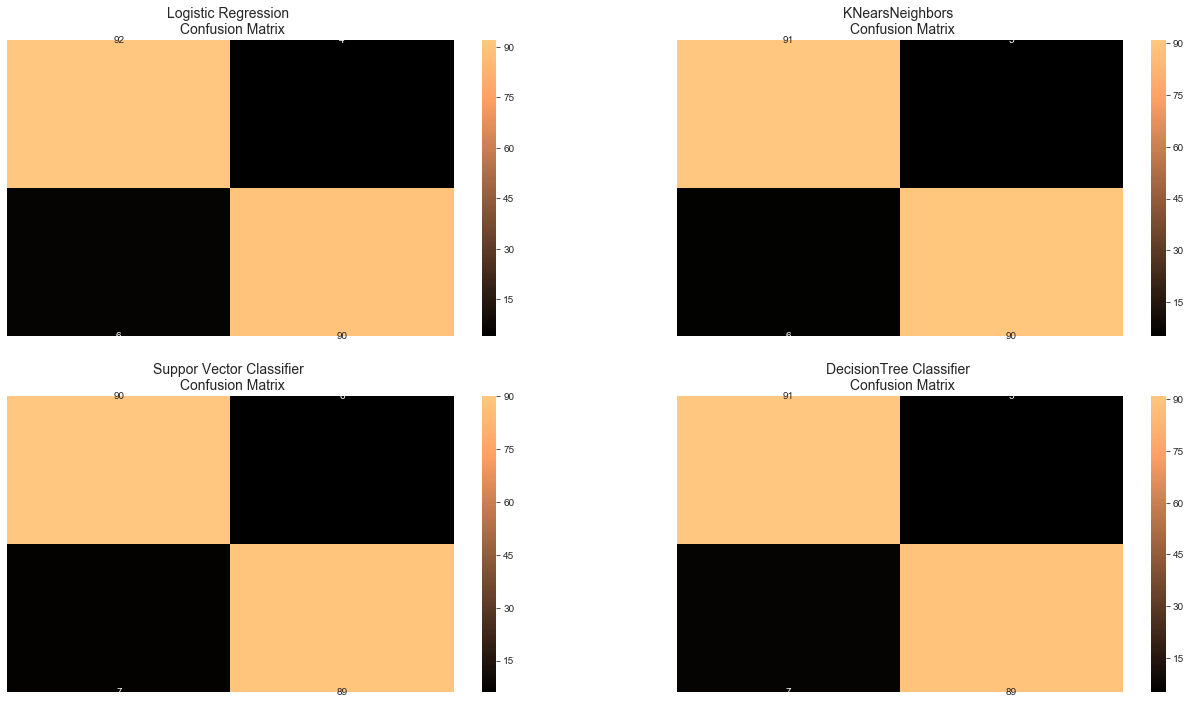

In [28]:
#over sampling한 데이터로 예측한 결과 cofusion matrix로 나타내고 이를 heatmap으로 표현
y_pred_log_reg = log_reg_sm.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

#confusion matrix->(tp, tn, fp, fn)에 대한 정보 담고 있는 행렬
# tp  fn
# fp  tn
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

sns.set_style(style='whitegrid')
fig, ax = plt.subplots(2,2, figsize=(22,12))
#annot->크기 숫자로 표시, cmap->디자인
sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [29]:
print('Logistic Regression')
print(classification_report(y_test, y_pred_log_reg))
print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))
print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))
print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        96
           1       0.96      0.94      0.95        96

    accuracy                           0.95       192
   macro avg       0.95      0.95      0.95       192
weighted avg       0.95      0.95      0.95       192

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        96
           1       0.95      0.94      0.94        96

    accuracy                           0.94       192
   macro avg       0.94      0.94      0.94       192
weighted avg       0.94      0.94      0.94       192

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        96
           1       0.94      0.93      0.93        96

    accuracy                           0.93       192
   macro avg       0.93      0.93      0.93       192
weighted 

In [34]:
#under(log_reg) vs over(log_reg_sm)
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)
y_pred_sm = log_reg_sm.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique':['UnderSampling(Near Miss)', 'OverSampling(SMOTE)'],
  'Score':[undersample_score, oversample_score]}
final_df = pd.DataFrame(data = d)

score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Technique,Score
0,UnderSampling(Near Miss),0.947917
1,OverSampling(SMOTE),0.988378


In [36]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [38]:
n_inputs = X_train.shape[1]
undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='relu')
])

In [39]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 611 samples, validate on 153 samples
Epoch 1/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 2/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 3/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 4/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 5/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 6/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 7/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 8/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 9/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 10/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 11/20
 - 0s - loss: 0.5732 - acc: 0.5106 - val_loss: 1.0541 - val_acc: 0.5425
Epoch 12/20
 - 0s - loss: 0.5732 - acc:

In [47]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)
undersample_cm=confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm=confusion_matrix(original_ytest, original_ytest)
print(undersample_cm)
print(actual_cm)

[[56854     9]
 [   98     0]]
[[56863     0]
 [    0    98]]


In [48]:
#Oversample
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
#verbose->0, 1, 2
#0->silent 1->progress bar 2->one line per epoch
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 5s - loss: 0.0649 - acc: 0.9760 - val_loss: 0.0170 - val_acc: 0.9974
Epoch 2/20
 - 5s - loss: 0.0110 - acc: 0.9978 - val_loss: 0.0061 - val_acc: 0.9998
Epoch 3/20
 - 5s - loss: 0.0060 - acc: 0.9989 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 4/20
 - 5s - loss: 0.0041 - acc: 0.9992 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 5/20
 - 4s - loss: 0.0034 - acc: 0.9994 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 6/20
 - 5s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 7/20
 - 5s - loss: 0.0028 - acc: 0.9995 - val_loss: 4.7642e-04 - val_acc: 1.0000
Epoch 8/20
 - 5s - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 9/20
 - 5s - loss: 0.0021 - acc: 0.9996 - val_loss: 4.9562e-04 - val_acc: 1.0000
Epoch 10/20
 - 6s - loss: 0.0018 - acc: 0.9997 - val_loss: 9.2551e-04 - val_acc: 1.0000
Epoch 11/20
 - 5s - loss: 0.0014 - acc: 0.9997 - val_loss: 1.9837e-04 - val_acc: 1.0000
Epoch 12/20
 - 5s 

In [50]:
oversample_fraud_predictions=oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)
oversample_cm=confusion_matrix(original_ytest,oversample_fraud_predictions)
actual_cm=confusion_matrix(original_ytest,original_ytest)
print(oversample_cm)
print(actual_cm)

[[56848    15]
 [   30    68]]
[[56863     0]
 [    0    98]]
